# Accuracy vs Confidence

The authors display in Figure 1 the relation between accuracy and confidence of a VGG-16 network on a CIFAR-100 `validation` set.
CIFAR-100 comes with a standard `train-test` split however, the validation set is not standard and the paper does not explain the process of constructing one. 

In this experiment we select `test` to be the validation set which is referred to by the authors. 

In [12]:
import torch
import torchvision
from torchvision.datasets import CIFAR100
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim import SGD, lr_scheduler
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from models.vgg import vgg16_bn
# from utils import compute_calibration_metrics
plt.rcParams["figure.figsize"] = (1,1)
%matplotlib inline

In [13]:
### Check for the device currently in use
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [14]:
### CIFAR100 specific values
mean = (0.5070751592371323, 0.48654887331495095, 0.4409178433670343)
std_dev = (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)

In [15]:
### Plotting function
def plot(xs, ys, epoch):
    fig = plt.figure()
    g = sns.jointplot(xs, ys, kind='kde', color='b', xlim=(None, 1), ylim=(None, 1), shaded=False)
    g.ax_joint.set_xlabel('average winning score')
    g.ax_joint.set_ylabel('average accuracy')
    g.fig.suptitle('Epoch:{}'.format(epoch))
    plt.show()

In [16]:
### Hyperparameters
epochs = 200    
data_collection_milestones = [0, 50, 100, 150, epochs-1]
learning_rate = 0.1     # This value seems to be working for pytorch
learning_rate_milestones = [60, 120, 180]
learning_gamma = 0.2  
nesterov = True
momentum = 0.9    # exact value NOT specified in the paper
weight_decay = 0.0005

## 1. Regular Training

Generating results corresponding to Figure 1-a,b,c,d,e

In [17]:
### Output dirs for the experiments
regular_output_root = './checkpoints/prelim/regular'

In [18]:
### The paper does not explain if it uses the `standard` augmentation techniques or not
### Following Mixup[28] we use the standard augmentations as mentioned below

transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean, std_dev)
    ])

transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std_dev)
])

train_dataset = CIFAR100(root='./data/', train=True, transform=transform_train, download=True)
test_dataset = CIFAR100(root='./data/', train=False, transform=transform_test, download=True)

Files already downloaded and verified
Files already downloaded and verified


0.0412


<Figure size 432x288 with 0 Axes>

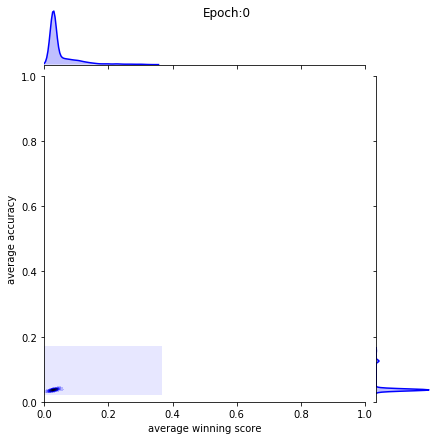

0.4284


<Figure size 432x288 with 0 Axes>

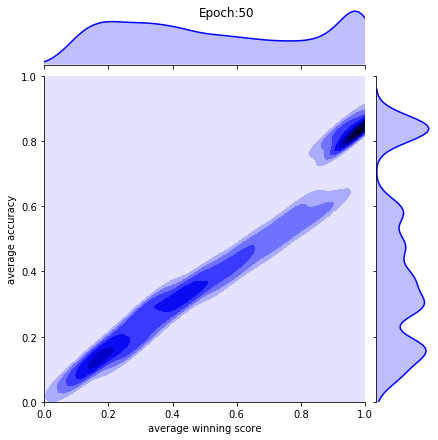

0.62


<Figure size 432x288 with 0 Axes>

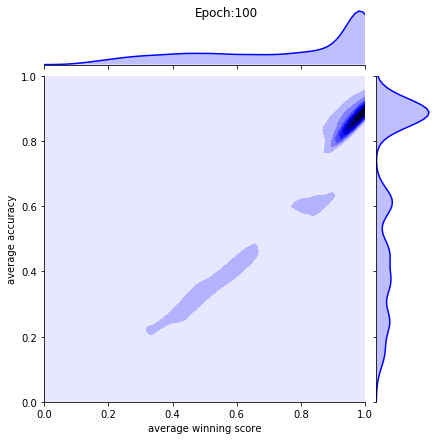

0.7016


<Figure size 432x288 with 0 Axes>

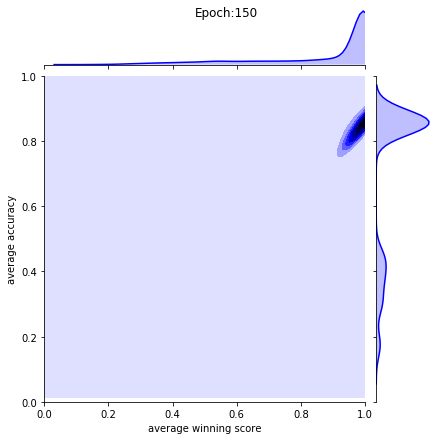

0.7196


<Figure size 432x288 with 0 Axes>

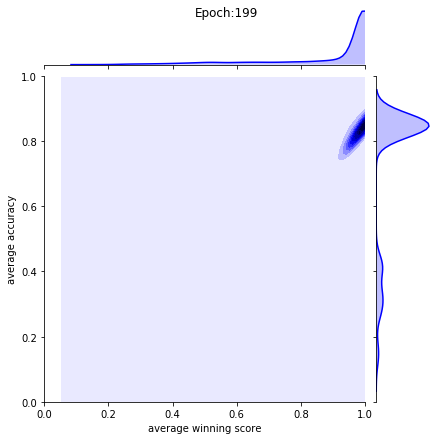

In [20]:
### Loading the model
#vgg = torchvision.models.vgg16_bn(pretrained=False, num_classes=100)
vgg = vgg16_bn()
vgg = vgg.to(device)

### Optimiser
optimiser = SGD(vgg.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum, nesterov=nesterov)
scheduler = lr_scheduler.MultiStepLR(optimiser, milestones=learning_rate_milestones, gamma=learning_gamma)

### The loss function
criterion = torch.nn.CrossEntropyLoss()

### The paper does not mention the batch size if used and the x and y labels are inconsitent 
batch_size = 128 
train_loader = DataLoader(train_dataset, shuffle=True, num_workers=2, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=True, num_workers=2, batch_size=batch_size)

accuracies = []
means_of_winning_score = []
for epoch in range(epochs):
    vgg.train()
    for idx, (images, labels) in enumerate(train_loader):
        optimiser.zero_grad()
        outputs = vgg(images.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimiser.step()
    scheduler.step()
    
    if epoch in data_collection_milestones:
        ece, oe, bin_acc, bin_conf, A = compute_calibration_metrics(net=vgg, loader=test_loader)
        print(A)
#         vgg.eval()
#         with torch.no_grad():
#             for idx, (images, labels) in enumerate(test_loader):
#                 outputs = vgg(images.to(device))
#                 probabilities = torch.nn.functional.softmax(outputs, dim=1)
#                 confs, preds = probabilities.max(1)
#                 correct = preds.eq(labels.to(device)).sum()
#                 accuracy.append((correct.cpu()/float(len(images))).item())
#                 winning_score.append(torch.mean(confs).item())
        plot(np.asarray(bin_conf), np.asarray(bin_acc), epoch)